# E-Commerce Analytics: Funnel, Cohort, CLV & Marketing ROI

This notebook connects to the SQLite database created in the previous step and explores several core e-commerce metrics, including:

- Overall visitor → buyer conversion  
- Performance by marketing channel  
- Cohort behaviour over time  
- Customer Lifetime Value (CLV)  
- Marketing ROI  

The aim is to understand user behaviour from acquisition through to repeat purchase.



In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the e-commerce database
conn = sqlite3.connect('../data/processed/ecommerce.db')


## 2. Overall funnel

First, we look at the high-level performance of the site:

- How many unique users visited?
- How many completed an order?
- What proportion of visitors converted into buyers?



In [2]:
# Total number of unique visitors
visitors_df = pd.read_sql("""
    SELECT COUNT(DISTINCT user_id) AS total_visitors
    FROM sessions
""", conn)

# Total number of unique buyers (completed orders only)
buyers_df = pd.read_sql("""
    SELECT COUNT(DISTINCT user_id) AS total_buyers
    FROM orders
    WHERE order_status = 'completed'
""", conn)

total_visitors = visitors_df['total_visitors'][0]
total_buyers = buyers_df['total_buyers'][0]
conversion_rate = total_buyers / total_visitors * 100

print(f"Total unique visitors: {total_visitors}")
print(f"Total unique buyers:   {total_buyers}")
print(f"Overall conversion rate: {conversion_rate:.2f}%")


Total unique visitors: 500
Total unique buyers:   363
Overall conversion rate: 72.60%


## 3. Funnel by marketing channel

Next, we break down the funnel by marketing channel to compare:

- Visitor volume  
- Buyer volume  
- Conversion rate  



In [3]:
# Visitors per marketing channel (based on signup channel)
visitors_channel = pd.read_sql("""
    SELECT marketing_channel, COUNT(DISTINCT user_id) AS visitors
    FROM users
    GROUP BY marketing_channel
""", conn)

# Buyers per marketing channel (completed orders only)
buyers_channel = pd.read_sql("""
    SELECT u.marketing_channel, COUNT(DISTINCT o.user_id) AS buyers
    FROM orders o
    JOIN users u ON o.user_id = u.user_id
    WHERE o.order_status = 'completed'
    GROUP BY u.marketing_channel
""", conn)

# Combine visitors and buyers and calculate conversion rate
funnel_channel = pd.merge(visitors_channel, buyers_channel, on='marketing_channel')
funnel_channel['conversion_rate'] = (
    funnel_channel['buyers'] / funnel_channel['visitors'] * 100
)

print("Funnel metrics by marketing channel:")
print(funnel_channel)


Funnel metrics by marketing channel:
  marketing_channel  visitors  buyers  conversion_rate
0             Email       121      79        65.289256
1        Google Ads       119      92        77.310924
2          Referral       134      93        69.402985
3      Social Media       126      99        78.571429


In [4]:
funnel_channel.sort_values('conversion_rate', ascending=False)


,marketing_channel,visitors,buyers,conversion_rate
3,Social Media,126,99,78.571429
1,Google Ads,119,92,77.310924
2,Referral,134,93,69.402985
0,Email,121,79,65.289256


## 4. Cohort analysis (signup month)

To understand longer-term behaviour, users are grouped into cohorts based on their signup month.  
We then count how many users remain active (i.e., place at least one order) in subsequent months.



In [5]:
# Load users and completed orders from the database
users = pd.read_sql("SELECT user_id, signup_date FROM users", conn)
orders = pd.read_sql("""
    SELECT user_id, order_date
    FROM orders
    WHERE order_status = 'completed'
""", conn)

# Convert dates to datetime
users['signup_date'] = pd.to_datetime(users['signup_date'])
orders['order_date'] = pd.to_datetime(orders['order_date'])

# Assign each user to a cohort (month of signup)
users['cohort_month'] = users['signup_date'].dt.to_period('M')

# Attach cohort info to each order
orders = orders.merge(users[['user_id', 'cohort_month']], on='user_id')

# Month of each order
orders['order_month'] = orders['order_date'].dt.to_period('M')

# Count unique active users per cohort per order month
cohort_data = (
    orders
    .groupby(['cohort_month', 'order_month'])['user_id']
    .nunique()
    .reset_index()
)

# Pivot to get a cohort table
cohort_table = cohort_data.pivot(
    index='cohort_month',
    columns='order_month',
    values='user_id'
).fillna(0)

print("Active users per cohort per month:")
print(cohort_table)


Active users per cohort per month:
order_month   2024-11  2024-12  2025-01  2025-02  2025-03  2025-04  2025-05  \
cohort_month                                                                  
2023-12           0.0      3.0      1.0      1.0      1.0      3.0      2.0   
2024-01           0.0      3.0      5.0      4.0      0.0      0.0      3.0   
2024-02           0.0      3.0      0.0      1.0      0.0      2.0      3.0   
2024-03           0.0      3.0      2.0      2.0      0.0      1.0      1.0   
2024-04           0.0      3.0      1.0      1.0      3.0      1.0      2.0   
2024-05           0.0      1.0      1.0      0.0      3.0      2.0      2.0   
2024-06           0.0      2.0      3.0      0.0      2.0      0.0      3.0   
2024-07           0.0      2.0      6.0      2.0      1.0      3.0      3.0   
2024-08           1.0      2.0      2.0      0.0      2.0      2.0      3.0   
2024-09           0.0      0.0      1.0      1.0      3.0      3.0      3.0   
2024-10          

## 5. Cohort retention (% active each month)

Raw user counts can be hard to compare across cohorts.  
By converting counts to percentages, we can see retention patterns more clearly and identify which cohorts stay engaged.


In [6]:
import numpy as np

# Replace zeros with NaN so we can safely find the first non-zero value
cohort_no_zero = cohort_table.replace(0, np.nan)

# First non-NaN value in each row = approximate cohort size
cohort_sizes = cohort_no_zero.apply(lambda row: row.dropna().iloc[0], axis=1)

# Calculate retention %
retention_percent = cohort_no_zero.divide(cohort_sizes, axis=0) * 100
retention_percent = retention_percent.fillna(0)

print("Cohort retention percentages (rounded):")
print(retention_percent.round(1))


Cohort retention percentages (rounded):
order_month   2024-11  2024-12  2025-01  2025-02  2025-03  2025-04  2025-05  \
cohort_month                                                                  
2023-12           0.0    100.0     33.3     33.3     33.3    100.0     66.7   
2024-01           0.0    100.0    166.7    133.3      0.0      0.0    100.0   
2024-02           0.0    100.0      0.0     33.3      0.0     66.7    100.0   
2024-03           0.0    100.0     66.7     66.7      0.0     33.3     33.3   
2024-04           0.0    100.0     33.3     33.3    100.0     33.3     66.7   
2024-05           0.0    100.0    100.0      0.0    300.0    200.0    200.0   
2024-06           0.0    100.0    150.0      0.0    100.0      0.0    150.0   
2024-07           0.0    100.0    300.0    100.0     50.0    150.0    150.0   
2024-08         100.0    200.0    200.0      0.0    200.0    200.0    300.0   
2024-09           0.0      0.0    100.0    100.0    300.0    300.0    300.0   
2024-10     

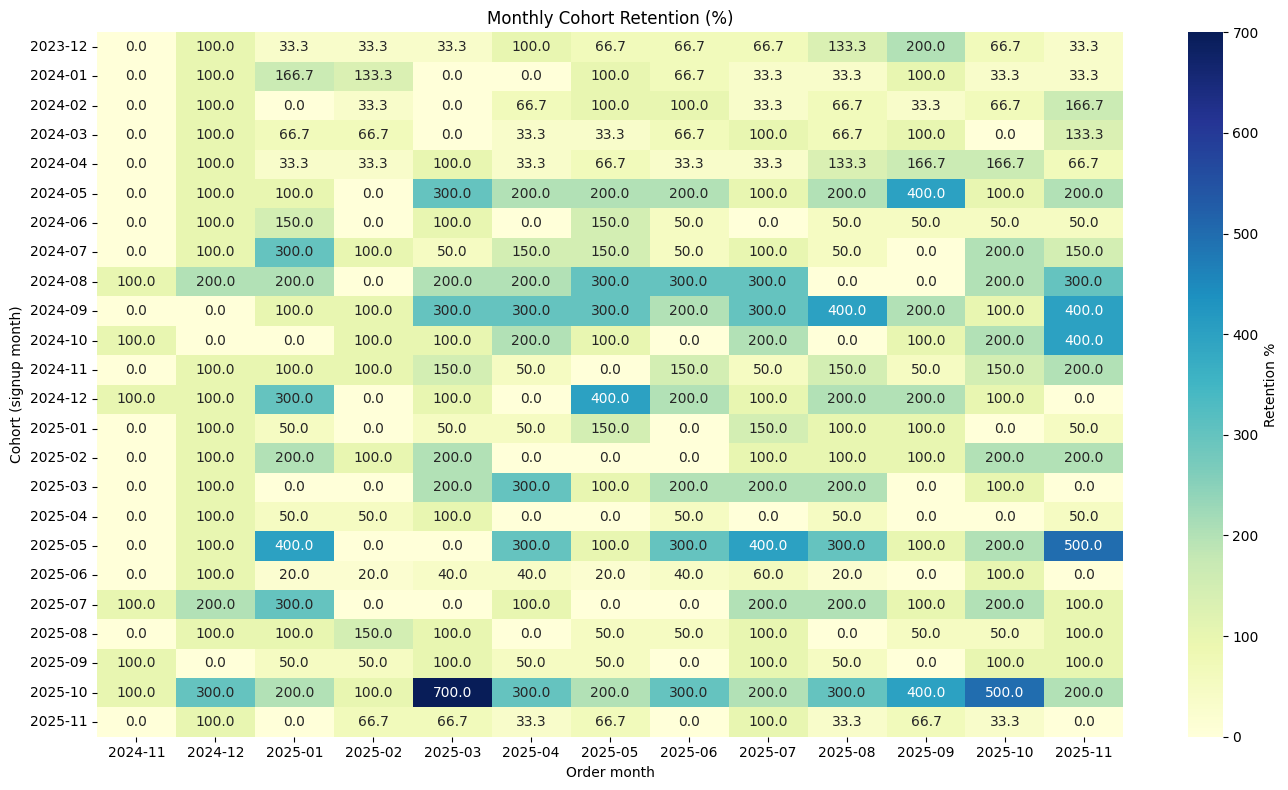

In [7]:
plt.figure(figsize=(14, 8))
sns.heatmap(
    retention_percent,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Retention %'}
)
plt.title("Monthly Cohort Retention (%)")
plt.xlabel("Order month")
plt.ylabel("Cohort (signup month)")
plt.tight_layout()
plt.show()


In [8]:
conn.close()
print("Database connection closed.")


Database connection closed.


## 6. Quick observations

Some short notes based on the cohort and funnel results:

- Certain signup months show stronger repeat activity than others.  
- Conversion rate varies meaningfully by marketing channel.  
- Retention drops after the first few months, which is common in e-commerce.  


## 7. Customer Lifetime Value (CLV)

To estimate the long-term value of each customer, we calculate three core metrics:

- **Recency:** How long since the user’s most recent purchase  
- **Frequency:** Number of completed orders  
- **Monetary value:** Total spend  

These are normalised and combined into a simple CLV score.



In [10]:
import sqlite3
import pandas as pd

# Reconnect to the e-commerce database
conn = sqlite3.connect('../data/processed/ecommerce.db')


In [12]:
# Load completed orders
orders = pd.read_sql("""
    SELECT user_id, order_date, total_amount
    FROM orders
    WHERE order_status = 'completed'
""", conn)

# Convert order_date to datetime
orders['order_date'] = pd.to_datetime(orders['order_date'])

# Reference date = last order date in the dataset
reference_date = orders['order_date'].max()

# CLV components
# ----------------------------------------

# Recency (days since last order)
recency = orders.groupby('user_id')['order_date'].max().apply(
    lambda x: (reference_date - x).days
)

# Frequency (number of completed orders)
frequency = orders.groupby('user_id')['order_date'].count()

# Monetary value (total spend)
monetary = orders.groupby('user_id')['total_amount'].sum()

# Combine into a single CLV base table
clv = pd.DataFrame({
    'recency_days': recency,
    'frequency': frequency,
    'monetary_value': monetary
})

clv.head()


,recency_days,frequency,monetary_value
user_id,,,
2,197,1,771.11
4,104,1,165.22
5,335,1,813.66
6,163,1,1385.41
8,109,2,3596.59


In [14]:
# Make a copy so we don't overwrite the original
clv_scaled = clv.copy()

# Normalise each column between 0 and 1 using min-max scaling
for col in ['recency_days', 'frequency', 'monetary_value']:
    col_min = clv_scaled[col].min()
    col_max = clv_scaled[col].max()
    if col_max > col_min:
        clv_scaled[col] = (clv_scaled[col] - col_min) / (col_max - col_min)
    else:
        clv_scaled[col] = 0  # edge case: all values the same

# Reverse recency so that lower recency (more recent) = higher score
clv_scaled['recency_days'] = 1 - clv_scaled['recency_days']

# Create final CLV score (weights can be adjusted)
clv_scaled['clv_score'] = (
    0.4 * clv_scaled['monetary_value'] +
    0.3 * clv_scaled['frequency'] +
    0.3 * clv_scaled['recency_days']
)

clv_scaled.head()



,recency_days,frequency,monetary_value,clv_score
user_id,,,,
2,0.458791,0.0,0.102622,0.178686
4,0.714286,0.0,0.019647,0.222144
5,0.079670,0.0,0.108450,0.067281
6,0.552198,0.0,0.186750,0.240359
8,0.700549,0.5,0.489568,0.555992


## 8. Marketing ROI by channel

Finally, we compare how much revenue each marketing channel generates against how much is spent on that channel.  
This highlights which channels provide the strongest return.



In [15]:
# Load marketing spend data
spend = pd.read_sql("""
    SELECT channel, spend_date, spend_amount
    FROM marketing_spend
""", conn)

# Total spend per channel
channel_spend = spend.groupby('channel')['spend_amount'].sum().reset_index()
channel_spend.rename(columns={'spend_amount': 'total_spend'}, inplace=True)

# Revenue per channel (based on users' signup channel)
revenue = pd.read_sql("""
    SELECT u.marketing_channel AS channel,
           SUM(o.total_amount) AS total_revenue
    FROM orders o
    JOIN users u ON o.user_id = u.user_id
    WHERE o.order_status = 'completed'
    GROUP BY u.marketing_channel
""", conn)

channel_revenue = revenue.copy()


In [16]:
# Combine spend and revenue
roi = pd.merge(channel_revenue, channel_spend, on='channel')

# ROAS: Return on Ad Spend = revenue / spend
roi['roas'] = roi['total_revenue'] / roi['total_spend']

# ROI: (revenue - spend) / spend
roi['roi'] = (roi['total_revenue'] - roi['total_spend']) / roi['total_spend']

roi


,channel,total_revenue,total_spend,roas,roi
0,Email,165675.30,49850.86,3.323419,2.323419
1,Google Ads,204052.40,56931.32,3.584185,2.584185
2,Referral,198855.63,67403.85,2.950212,1.950212
3,Social Media,217942.22,73789.73,2.953558,1.953558


## ROI insights

A few observations from the ROI figures:

- Channels with high revenue and relatively low spend rank best.  
- ROAS (Return on Ad Spend) and ROI give a clearer picture than spend alone.  
- In a real environment, budget would usually be shifted toward higher-return channels.  



In [17]:
conn.close()
print("Database connection closed.")


Database connection closed.
